In [1]:
from fastai.vision.all import *
import pdb

In [2]:
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [3]:
data_path = Path('data/')

In [4]:
data_path.ls()

(#5) [Path('data/dicom-images-test'),Path('data/dicom-images-train'),Path('data/pneumothorax'),Path('data/train-rle.csv'),Path('data/train')]

In [5]:
size=224
bs=64

In [6]:
def get_data(size,tfms=None,bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),*aug_transforms()]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','mask'))
    return db.dataloaders(source=data_path/'train'/'images',bs=bs)

In [7]:

dls = get_data(size=224,bs=64)

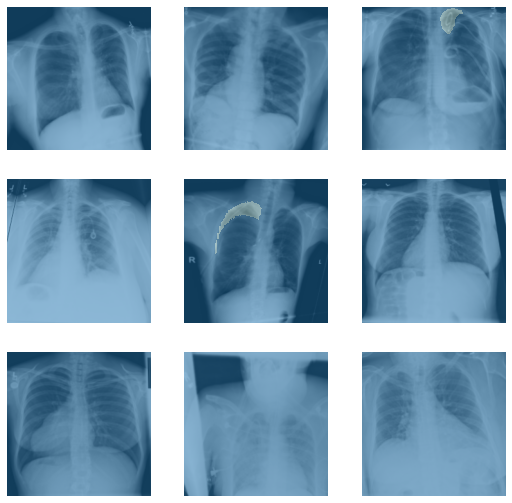

In [8]:
dls.show_batch(max_n=9)

### Training using default fastai Unet Learner

In [9]:
learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

### Building custom Unet Architecture

In [12]:
import timm

In [17]:
# timm.list_models(pretrained=True)

In [14]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class Unet(Module):
    def __init__(self, fs=32, expansion=4, model_name='resnext50_32x4d',n_out=1):
        self.encoder = timm.create_model(model_name, features_only=True, pretrained=True)
        center_ch = 512*expansion
        decoder5_ch = center_ch + (256*expansion)
        self.center = nn.Sequential(ConvLayer(center_ch,center_ch),ConvLayer(center_ch,center_ch//2))
        self.decoder5 = Decoder(decoder5_ch,512,fs) 
        self.decoder4 = Decoder(256*expansion+fs,256,fs) 
        self.decoder3 = Decoder(128*expansion+fs,128,fs)
        self.decoder2 = Decoder(64*expansion+fs,64,fs)
        self.decoder1 = Decoder(fs,fs,fs)
        self.logit = nn.Sequential(ConvLayer(fs*5,64),ConvLayer(64,32),nn.Conv2d(32,n_out,kernel_size=1))
        
    def forward(self, x):
        e1,e2,e3,e4,e5 = self.encoder(x) #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)

        f = torch.cat((
                 d1,
                 F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                 F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                 F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                 F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False),

        ), 1)

        logit = self.logit(f)
        return logit

### Using our new Unet

In [18]:
dls = get_data(size=224,bs=32)
learn = Learner(dls,Unet(expansion=1,model_name='resnet34'),loss_func=BCEWithLogitsLossFlat(), metrics=dice)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,dice,time
0,0.256699,0.174869,0.788601,02:22
1,0.040179,0.027801,0.799629,02:21
2,0.018738,0.015653,0.791795,02:22
3,0.013440,0.010680,0.807279,02:21
4,0.010930,0.009889,0.817703,02:22


### Adjust the LR based on LR find

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.04786301031708717)

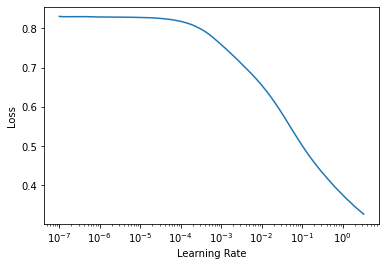

In [20]:
learn = Learner(dls,Unet(),loss_func=BCEWithLogitsLossFlat(), metrics=dice)
learn = learn.to_fp16()
learn.lr_find()

In [21]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.033559,0.015857,0.789773,02:49
1,0.018290,0.018974,0.405185,02:47
2,0.016063,0.013641,0.794841,02:47
3,0.015064,0.012822,0.790019,02:47
4,0.013047,0.010702,0.796107,02:47


### With Augmentations

In [26]:
learn = Learner(dls,Unet(),loss_func=BCEWithLogitsLossFlat(), metrics=dice)
learn = learn.to_fp16()

In [27]:
learn.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.045320,0.016703,0.780328,02:38
1,0.017669,0.014153,0.779388,02:39
